[INFO] creating woe binning ...
Binning on 142046 rows and 125 columns in 00:01:24
[INFO] converting into woe values ...
Woe transformating on 142046 rows and 124 columns in 00:00:49
[INFO] converting into woe values ...
Woe transformating on 60878 rows and 124 columns in 00:00:21


C:\Users\Faez\anaconda3\lib\site-packages\scorecardpy\scorecard.py:353: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat_score.loc[:,'score'] = card_basepoints + dat_score.sum(axis=1)


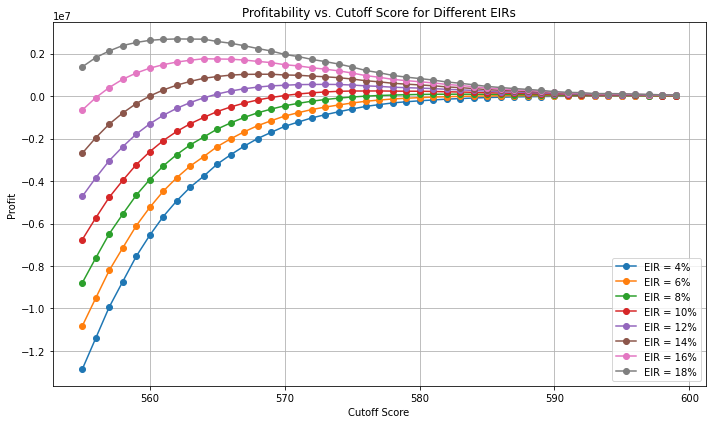

Best cutoff for EIR 4%: 599, Profit = $1,467.96
Best cutoff for EIR 6%: 589, Profit = $18,065.53
Best cutoff for EIR 8%: 583, Profit = $87,143.52
Best cutoff for EIR 10%: 577, Profit = $239,812.05
Best cutoff for EIR 12%: 573, Profit = $549,597.83
Best cutoff for EIR 14%: 569, Profit = $1,026,358.91
Best cutoff for EIR 16%: 564, Profit = $1,755,925.13
Best cutoff for EIR 18%: 562, Profit = $2,688,708.82


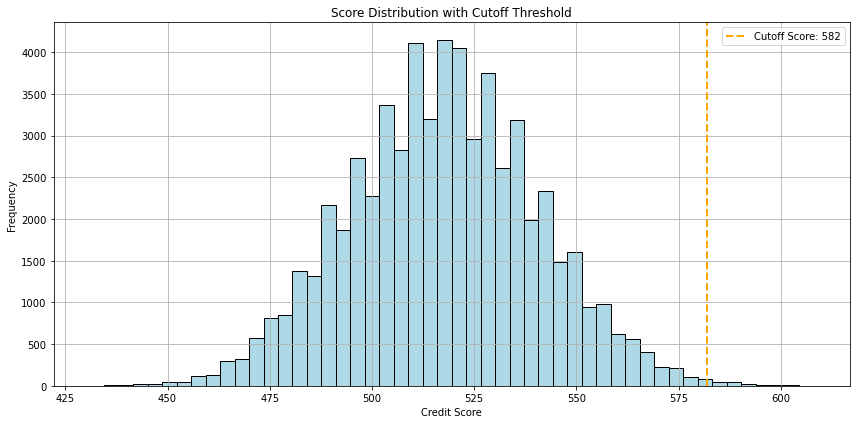

Percentage of applicants exceeding the cutoff of 582: 0.25%


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scorecardpy as sc
import random


data = pd.read_csv('final_dataset.csv')
data = data.replace([np.inf, -np.inf], np.nan)
train, test = sc.split_df(data, y='TARGET', ratio=0.7).values()
train = train.drop(columns=['ORGANIZATION_TYPE'], errors='ignore')
test = test.drop(columns=['ORGANIZATION_TYPE'], errors='ignore')


with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y='TARGET')
train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe.fillna(0, inplace=True)
test_woe.fillna(0, inplace=True)


X_train = train_woe.drop(columns='TARGET')
y_train = train_woe['TARGET']
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)


card = sc.scorecard(bins, model, X_train.columns, points0=600, odds0=1/20, pdo=20, basepoints_eq0=True)
flat_card = pd.concat(card.values(), ignore_index=True)
# flat_card.to_csv("scorecard_table.csv", index=False)


test_score = sc.scorecard_ply(test, card, only_total_score=True)
test['score'] = test_score['score']


def get_default_prob(cutoff, base_odds=20, pdo=20, base_score=600):
    odds_at_cutoff = base_odds / 2 ** ((base_score - cutoff) / pdo)
    return 1 / (1 + odds_at_cutoff)

avg_loan_amount = 41000
avg_loss_per_default = 28700
cutoff_scores = np.arange(555, 600, 1)
profits_dict = {}

for eir in range(4, 20, 2):
    profits = []
    for cutoff in cutoff_scores:
        approval_count = test[test["score"] > cutoff].shape[0]
        default_count = get_default_prob(cutoff) * approval_count
        revenue = (approval_count - default_count) * avg_loan_amount * (eir / 100)
        loss = default_count * avg_loss_per_default
        profit = revenue - loss
        profits.append(profit)
    profits_dict[eir] = profits

# Plotting
plt.figure(figsize=(10, 6))
for eir, profits in profits_dict.items():
    plt.plot(cutoff_scores, profits, marker='o', label=f'EIR = {eir}%')
plt.title("Profitability vs. Cutoff Score for Different EIRs")
plt.xlabel("Cutoff Score")
plt.ylabel("Profit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optimal cutoff for each EIR
for eir, profits in profits_dict.items():
    best_idx = np.argmax(profits)
    print(f"Best cutoff for EIR {eir}%: {cutoff_scores[best_idx]}, Profit = ${profits[best_idx]:,.2f}")


# # Plotting Credit scorecard simulation graph 
# valid_vars = [k for k in card if k != 'basepoints' and not card[k].empty]
# selected_vars = random.sample(valid_vars, min(15, len(valid_vars)))
# applicant = {}
# for var in selected_vars:
#     df = card[var]
#     if not df.empty:
#         bin_choice = df.sample(1)
#         bin_label = bin_choice['bin'].values[0]
#         points = bin_choice['points'].values[0]
#         applicant[var] = {'bin': bin_label, 'points': points}

# basepoints = card['basepoints']['points'].values[0]
# simulated_score = basepoints + sum(info['points'] for info in applicant.values())

# # Plot distribution of scores with cutoffs and simulated score
# plt.figure(figsize=(12, 6))
# plt.hist(test['score'], bins=50, color='lightblue', edgecolor='black')
# plt.axvline(x=600, color='orange', linestyle='--', label='Cutoff 600')
# plt.axvline(x=640, color='red', linestyle='--', label='Cutoff 640')
# plt.axvline(x=simulated_score, color='green', linestyle='-', linewidth=2, label='Simulated Applicant')
# plt.title('Score Distribution with Cutoff Thresholds')
# plt.xlabel('Score')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# print(f"Simulated applicant score: {simulated_score:.2f}")

# Plot distribution of scores with just the cutoff (no applicant simulation)
plt.figure(figsize=(12, 6))
plt.hist(test['score'], bins=50, color='lightblue', edgecolor='black')

# Highlight the cutoff score at 582
cutoff_score = 582
plt.axvline(x=cutoff_score, color='orange', linestyle='--', linewidth=2, label=f'Cutoff Score: {cutoff_score}')

# Plot settings
plt.title('Score Distribution with Cutoff Threshold')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

cutoff_score = 582
num_above_cutoff = test[test['score'] > cutoff_score].shape[0]
total_applicants = test.shape[0]

percentage_above_cutoff = (num_above_cutoff / total_applicants) * 100
print(f"Percentage of applicants exceeding the cutoff of {cutoff_score}: {percentage_above_cutoff:.2f}%")








Top 15 variables most correlated with TARGET:
EXT_SOURCE_1                  -0.165712
DAYS_CREDIT_mean               0.093077
DAYS_BIRTH                     0.092285
DAYS_CREDIT_min                0.079370
CREDIT_ACTIVE_<lambda>         0.070435
REG_CITY_NOT_WORK_CITY         0.062215
DAYS_ID_PUBLISH                0.060284
REGION_RATING_CLIENT_W_CITY    0.059896
DAYS_LAST_PHONE_CHANGE         0.058236
REGION_RATING_CLIENT           0.058064
FLAG_EMP_PHONE                 0.057188
DAYS_EMPLOYED                 -0.056141
REG_CITY_NOT_LIVE_CITY         0.049014
DAYS_REGISTRATION              0.047888
FLAG_DOCUMENT_3                0.044945
Name: TARGET, dtype: float64
[INFO] creating woe binning ...
Binning on 142046 rows and 16 columns in 00:00:10
[INFO] converting into woe values ...
[INFO] converting into woe values ...


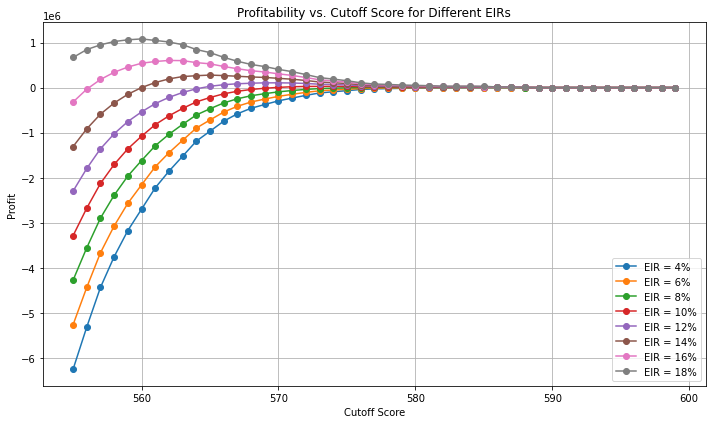

Best cutoff for EIR 4%: 589, Profit = $0.00
Best cutoff for EIR 6%: 587, Profit = $579.28
Best cutoff for EIR 8%: 584, Profit = $5,032.53
Best cutoff for EIR 10%: 574, Profit = $27,747.71
Best cutoff for EIR 12%: 569, Profit = $105,229.88
Best cutoff for EIR 14%: 565, Profit = $277,530.49
Best cutoff for EIR 16%: 562, Profit = $601,887.47
Best cutoff for EIR 18%: 560, Profit = $1,079,666.67


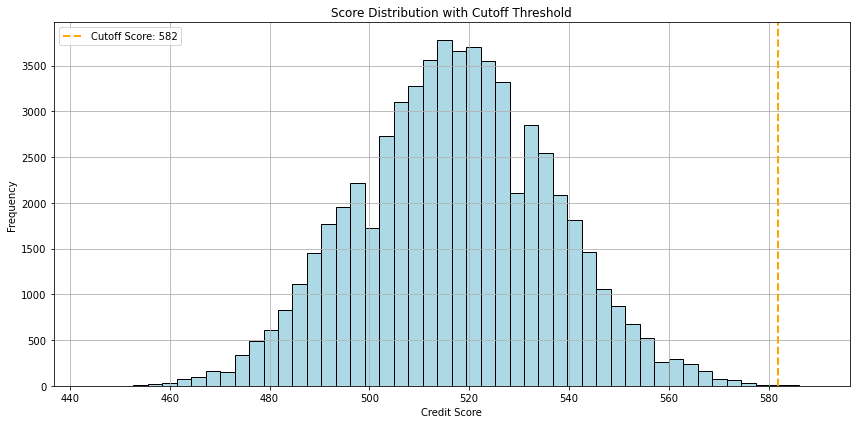

Percentage of applicants exceeding the cutoff of 582: 0.01%


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import scorecardpy as sc
import random

df = pd.read_csv('final_dataset.csv')
df = df.replace([np.inf, -np.inf], np.nan)

#Find the top 15 numerical variables correlated with TARGET variable 
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlations = numeric_df.corr()['TARGET'].drop('TARGET')
top_15 = correlations.abs().sort_values(ascending=False).head(15)
top_15_named = correlations.loc[top_15.index]
print("Top 15 variables most correlated with TARGET:")
print(top_15_named)

# Subset dataframe to top 15 + TARGET
selected_cols = top_15_named.index.tolist() + ['TARGET']
df_subset = df[selected_cols].copy()


train, test = sc.split_df(df_subset, y='TARGET', ratio=0.7).values()

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    bins = sc.woebin(train, y='TARGET')

train_woe = sc.woebin_ply(train, bins)
test_woe = sc.woebin_ply(test, bins)
train_woe.fillna(0, inplace=True)
test_woe.fillna(0, inplace=True)


X_train = train_woe.drop(columns='TARGET')
y_train = train_woe['TARGET']
model = LogisticRegression(solver='liblinear', class_weight='balanced')
model.fit(X_train, y_train)


card = sc.scorecard(bins, model, X_train.columns, points0=600, odds0=1/20, pdo=20, basepoints_eq0=True)
flat_card = pd.concat(card.values(), ignore_index=True)
flat_card.to_csv("scorecard_table_15_variables.csv", index=False)


test_score = sc.scorecard_ply(test, card, only_total_score=True)
test['score'] = test_score['score']


def get_default_prob(cutoff, base_odds=20, pdo=20, base_score=600):
    odds_at_cutoff = base_odds / 2 ** ((base_score - cutoff) / pdo)
    return 1 / (1 + odds_at_cutoff)

avg_loan_amount = 41000
avg_loss_per_default = 28700
cutoff_scores = np.arange(555, 600, 1)
profits_dict = {}

for eir in range(4, 20, 2):
    profits = []
    for cutoff in cutoff_scores:
        approval_count = test[test["score"] > cutoff].shape[0]
        default_count = get_default_prob(cutoff) * approval_count
        revenue = (approval_count - default_count) * avg_loan_amount * (eir / 100)
        loss = default_count * avg_loss_per_default
        profit = revenue - loss
        profits.append(profit)
    profits_dict[eir] = profits

# Plotting
plt.figure(figsize=(10, 6))
for eir, profits in profits_dict.items():
    plt.plot(cutoff_scores, profits, marker='o', label=f'EIR = {eir}%')
plt.title("Profitability vs. Cutoff Score for Different EIRs")
plt.xlabel("Cutoff Score")
plt.ylabel("Profit")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Optimal cutoff for each EIR
for eir, profits in profits_dict.items():
    best_idx = np.argmax(profits)
    print(f"Best cutoff for EIR {eir}%: {cutoff_scores[best_idx]}, Profit = ${profits[best_idx]:,.2f}")

# print(f"Simulated applicant score: {simulated_score:.2f}")

# Plot distribution of scores with just the cutoff (no applicant simulation)
plt.figure(figsize=(12, 6))
plt.hist(test['score'], bins=50, color='lightblue', edgecolor='black')

# Highlight the cutoff score at 582
cutoff_score = 582
plt.axvline(x=cutoff_score, color='orange', linestyle='--', linewidth=2, label=f'Cutoff Score: {cutoff_score}')

# Plot settings
plt.title('Score Distribution with Cutoff Threshold')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

cutoff_score = 582
num_above_cutoff = test[test['score'] > cutoff_score].shape[0]
total_applicants = test.shape[0]

percentage_above_cutoff = (num_above_cutoff / total_applicants) * 100
print(f"Percentage of applicants exceeding the cutoff of {cutoff_score}: {percentage_above_cutoff:.2f}%")